In [1]:
import os
import shutil
import pathlib
from tqdm import tqdm
import math
import numpy as np
import scipy as sp
import pandas as pd
import re
import json
import yaml
import random
try:
    from yaml import CSafeLoader as Loader
except ImportError:
    from yaml import SafeLoader as Loader
import subprocess
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", palette="tab10")
plt.style.use(["xzc_notebook"])
# plt.rcParams['figure.dpi'] = 200
# pd.options.display.max_columns = None
# pd.options.mode.chained_assignment = None  # default='warn'
def set_size(w, h, ax=None):
    """ w, h: width, height in inches """
    if not ax:
        ax = plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [2]:
def read_ak(filename, T):
    df = pd.read_csv(filename, sep="\s+", comment='#', header=None)
    return df.iloc[-1, 1], df.iloc[-1, -1]

In [3]:
# Physical constants.
kB = sp.constants.value('Boltzmann constant in eV/K')
eV = sp.constants.value('electron volt')
hbar = sp.constants.value('Planck constant over 2 pi in eV s')
mu = sp.constants.value('atomic mass constant')

In [4]:
m = 55.845# Iron mass [g].
n = 18 # Number of unit cells in each direction.
natoms = n**3*2 # Number of atoms.
T = np.array(range(100, 1601, 100)) # [K].
a, k= np.zeros(len(T)), np.zeros(len(T)) # [A] and [eV/A^2].
for i, this_T in enumerate(T):
    l, msd = read_ak(f"./lattice_spring_langevin/lattice/msd_{this_T}.dat", this_T)
    a[i] = l/18
    k[i] = 3*kB*this_T/msd 
    

In [5]:
RANDOM = 1
for this_T, this_a, this_k in zip(T, a, k):
    print(f"Running Frenkel-Ladd at T={this_T}K...")
    !cd ./frenkel_ladd && HWLOC_HIDE_ERRORS=2 mpirun --oversubscribe -np 64 lmp -in in.lammps \
            -log log/lammps_{this_T}K.log \
            -screen none                  \
            -var T {this_T}               \
            -var a {this_a}               \
            -var k {this_k}               \
            -var RANDOM {RANDOM}


Running Frenkel-Ladd at T=100K...
Running Frenkel-Ladd at T=200K...
Running Frenkel-Ladd at T=300K...
Running Frenkel-Ladd at T=400K...
Running Frenkel-Ladd at T=500K...
Running Frenkel-Ladd at T=600K...
Running Frenkel-Ladd at T=700K...
Running Frenkel-Ladd at T=800K...
Running Frenkel-Ladd at T=900K...
Running Frenkel-Ladd at T=1000K...
Running Frenkel-Ladd at T=1100K...
Running Frenkel-Ladd at T=1200K...
Running Frenkel-Ladd at T=1300K...
Running Frenkel-Ladd at T=1400K...
Running Frenkel-Ladd at T=1500K...
Running Frenkel-Ladd at T=1600K...


In [6]:
RANDOM = 1
print(f"Running reversible scaling...")
!cd ./reversible_scaling &&HWLOC_HIDE_ERRORS=2 mpirun --oversubscribe -np 64 lmp -in in.lammps \
    -log log/lammps.log \
    -screen none        \
    -var RANDOM {RANDOM}


Running reversible scaling...


In [10]:
# Frenkel-Ladd integration
work = np.zeros(len(T)) # [eV] Reversible work for each temperature.
for i, this_T in enumerate(T):
    dE, lamb = np.loadtxt(f'./frenkel_ladd/data/forward_{this_T}K.dat' , unpack=True)
    I_forw = np.trapz(dE,lamb)
    dE, lamb = np.loadtxt(f'./frenkel_ladd/data/backward_{this_T}K.dat' , unpack=True)
    I_back = np.trapz(dE,lamb)
    work[i] = ((I_forw - I_back)/2)

# Define harmonic reference system free energy
omega = np.sqrt(k*eV/(m*mu))*1e10 # [1/s].
F_harm = 3*natoms*kB*T * np.log(hbar*omega/(kB*T)) # [eV].
# Fixed center of mass correction [Eq.(24) in the paper].
V = (a*n)**3 # Total volume.
F_CM = (kB*T)*np.log((natoms/V) * (2*np.pi*kB*T / (natoms*k))**(3./2.)) 
F = (F_harm + work + F_CM) / natoms # [eV/atom].
df = pd.DataFrame({'T [K]': T, 'F [eV/atom]': F})
df.to_csv('FL.csv', index=False)

In [11]:
# Reversible scaling integration
T0 = 100 # Reference temperature [K]
F0 = F[T==T0]
# Load potential energy and lambda.
U_f, lamb_f = np.loadtxt('./reversible_scaling/data/forward.dat', unpack=True)
U_b, lamb_b = np.loadtxt('./reversible_scaling/data/backward.dat', unpack=True)
# Fix adapt also scales the potential energy besides the forces, so we unscale.
U_f /= lamb_f
U_b /= lamb_b
# Compute work done using cummulative integrals [Eq.(21) in the paper].
I_f = sp.integrate.cumtrapz(U_f,lamb_f,initial=0)
I_b = sp.integrate.cumtrapz(U_b[::-1],lamb_b[::-1],initial=0)
W = (I_f+I_b) / (2*lamb_f)
# Compute free energy [Eq.(22) in the paper] and save results.
T_rc = T0/lamb_f
F_rc = F0/lamb_f + 1.5*kB*T_rc*np.log(lamb_f) + W
df = pd.DataFrame({'T [K]': T_rc, 'F [eV/atom]': F_rc})
df.to_csv('RC.csv', index=False)

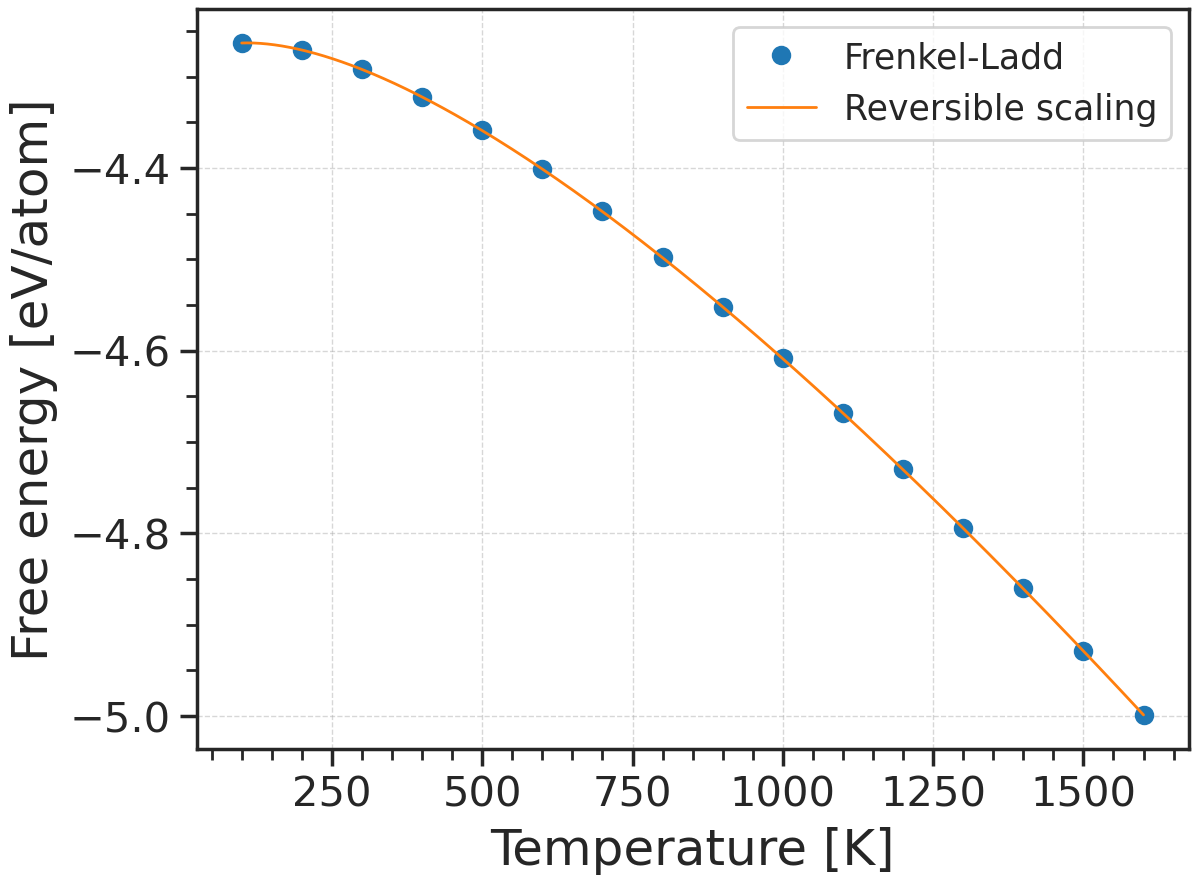

In [12]:
# Start figure.
fig, ax = plt.subplots()

# df = pd.read_csv('FL_base.csv')
# ax.plot(df['T [K]'], df['F [eV/atom]'], 'o', lw=1)

df = pd.read_csv('FL.csv')
ax.plot(df['T [K]'], df['F [eV/atom]'], 'o', lw=1, label='Frenkel-Ladd')

df = pd.read_csv('RC.csv')
ax.plot(df['T [K]'], df['F [eV/atom]'], '-', lw=1, label='Reversible scaling')

ax.set_xlabel(r'Temperature [K]')
ax.set_ylabel(r'Free energy [eV/atom]')
ax.legend()
